## Contents
In this notebook we will

* Construct an approximation of the hyperparameter posterior of a Gaussian Process regression model, and draw posterior function samples.
* Approximate the distribution of the input to a GP conditioned on various conditions, as well as propagate an uncertain input through a GP. 

In [1]:
import corner
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import tensorflow as tf
import matplotlib.pylab as plt
import tensorflow_probability as tfp
from defer.helpers import *
from defer.variables import Variable
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

### Generate data
Generate training data with a known level of Gaussian noise.
We will recover the noise level from the data later.

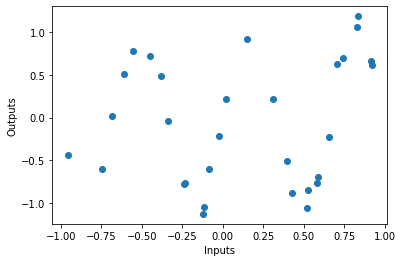

In [2]:
def sinusoid(x):
      return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_points, observation_noise_variance):
    index_points_ = np.random.uniform(-1., 1., (num_points, 1))
    index_points_ = index_points_.astype(np.float64)
    noise = np.random.normal(
        loc=0,
        scale=np.sqrt(observation_noise_variance), 
        size=num_points
    )
    observations_ = sinusoid(index_points_) + noise
    return index_points_, observations_

num_obs = 30
observation_index_points_, observations_ = generate_1d_data(
    num_points=num_obs,
    observation_noise_variance=1e-2)

plt.scatter(observation_index_points_, observations_)
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.show()

### Set up model
Set up the Gaussian Process model and the density function of the parameters we wish to recover.

In [3]:
def gaussian_process(amplitude, length_scale, observation_noise_variance):
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)
  return tfd.GaussianProcess(
      kernel=kernel,
      index_points=observation_index_points_,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations': gaussian_process,
})

In [4]:
dtype = tf.float64
@tf.function(
    input_signature=(
        tf.TensorSpec(shape=(1,), dtype=dtype),
        tf.TensorSpec(shape=(1,), dtype=dtype),
        tf.TensorSpec(shape=(1,), dtype=dtype),
    )
)
def unnormalized_hyperparams_posterior(log_amplitude, log_length_scale, log_obs_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': tf.exp(log_amplitude),
      'length_scale': tf.exp(log_length_scale),
      'observation_noise_variance': tf.exp(log_obs_noise_variance),
      'observations': observations_
  })

### Set up and compute the density function approximation
Set up the variables corresponding to the GP hyper-parameters, 
and construct the density function (unnormalized posterior) approximation.

In [5]:
variables = Variables([
    Variable(lower=-10, upper=5, name="log amplitude"),
    Variable(lower=-10, upper=5, name="log lengthscale"),
    Variable(lower=-10, upper=5, name="log obs noise variance")
])

hyperparams_aup = construct(
    fn=unnormalized_hyperparams_posterior,
    is_log_fn=True,
    num_fn_calls=1000,
    variables=variables,
    callback=lambda i, current:
    print("#Iters: %s, #Partitions: %s. Log Z: %.2f" % (
      i + 1, current.num_partitions, np.log(current.z)
    )),
    callback_freq_fn_calls=500,
)
print("Approximation construction completed.")

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
#Iters: 1, #Partitions: 7. Log Z: -66.32
#Iters: 42, #Partitions: 511. Log Z: -12.46
#Iters: 104, #Partitions: 1001. Log Z: -12.45
Approximation construction completed.


Evidence (including marginalized hyperparameters)

In [6]:
hyperparams_aup.z

3.9025128338156010135e-06

Preparing sampler..
Sampling..
Plotting..


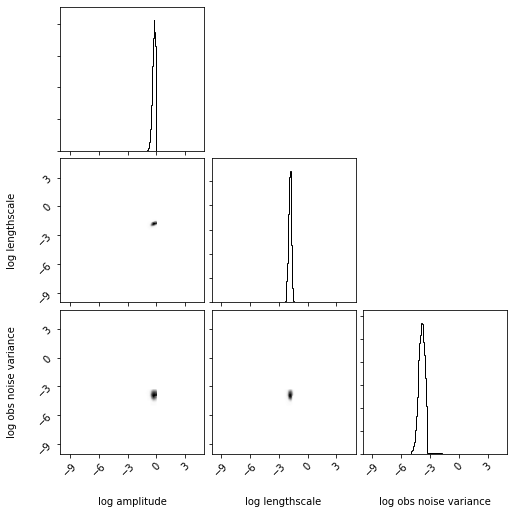

In [7]:
def plot(density: DensityFunctionApproximation):
    print("Preparing sampler..")
    sampler = density.sampler()
    print("Sampling..")
    samples_per_variable = sampler(num_samples=10 ** 5)
    samples = np.concatenate(samples_per_variable, axis=-1)
    print("Plotting..")
    figure = corner.corner(
        samples,
        range=density.variables.bounds,
        labels=[
            "%s" % var.name
            for var in density.variables.variable_slices
            for index in var.indices
        ],
        plot_contours=False,
        no_fill_contours=True,
        bins=150,
        plot_datapoints=False,
    )
    plt.show()
    
plot(hyperparams_aup)

### Sample GP hyper-parameters from the posterior
Sample hyper-parameters and construct a batch of kernels.

In [8]:
hyperparams_sampler = hyperparams_aup.sampler()
num_hyperparam_samples = 100
(
    log_amplitude_samples,
    log_length_scale_samples,
    log_obs_noise_variance_samples
) = hyperparams_sampler(num_samples=num_hyperparam_samples)

amplitude_samples = np.exp(log_amplitude_samples).flatten()
length_scale_samples = np.exp(log_length_scale_samples).flatten()
obs_noise_variance_samples = np.exp(log_obs_noise_variance_samples).flatten()

batch_of_posterior_kernels = tfk.ExponentiatedQuadratic(
    amplitude_samples,
    length_scale_samples,
)

Posterior GP approximation from sampled kernels

In [9]:
def gp_posterior(
    index_points, 
    noiseless_functions:bool
):
    if noiseless_functions:
        predictive_noise_variance = 0.
    else:
        predictive_noise_variance = obs_noise_variance_samples
    batch_gprm = tfd.GaussianProcessRegressionModel(
        kernel=batch_of_posterior_kernels,
        index_points=index_points,
        observation_index_points=observation_index_points_,
        observations=observations_,
        observation_noise_variance=obs_noise_variance_samples,
        predictive_noise_variance=predictive_noise_variance
    )
    # Approximates hyperparameter distribution as a mixture
    # over a finite set of hyperparameter samples.
    mixture_gprm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(
            logits=tf.zeros([num_hyperparam_samples], dtype=dtype)),
        components_distribution=batch_gprm)
    return mixture_gprm

Plot function samples

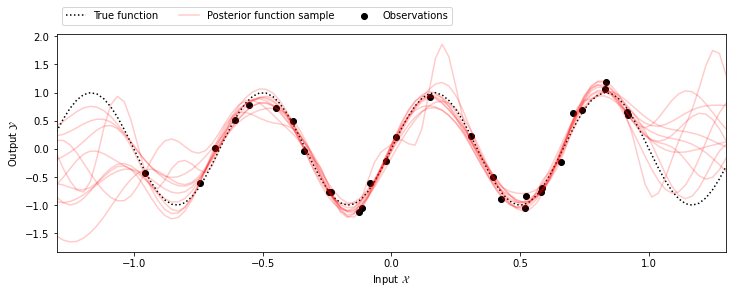

In [10]:
num_gp_samples = 10

x_lb = -1.3
x_ub = 1.3
predictive_index_points_ = np.linspace(x_lb, x_ub, 100, dtype=np.float64)[..., np.newaxis]

predictive_gprm = gp_posterior(
    index_points=predictive_index_points_,
    noiseless_functions=True
)

gp_samples = predictive_gprm.sample(num_gp_samples)

def plot_functions(axis=None):
    if axis is None:
        axis = plt.gca()
    axis.plot(
        predictive_index_points_, 
        sinusoid(predictive_index_points_),
        label='True function', linestyle="dotted", color="black")
    axis.scatter(
        observation_index_points_[:, 0], 
        observations_,
        label='Observations', color="black")
    for i in range(num_gp_samples):
        axis.plot(
            predictive_index_points_, 
            gp_samples[i, :], c='r', alpha=.2,
            label='Posterior function sample' if i == 0 else None)
    axis.set_xlabel(r"Input $\mathcal{X}$")
    axis.set_ylabel(r"Output $\mathcal{Y}$")
    axis.set_xlim(x_lb, x_ub)
    return fig
    
def plot_legend(ncol=1, loc='upper right'):
    leg = plt.legend(loc=loc, ncol=ncol)
    for lh in leg.legendHandles:
        lh.set_alpha(1)

fig = plt.figure(figsize=(12, 4))
plot_functions()
plt.legend(
    loc='upper left',
    ncol=3,
    bbox_to_anchor=(0, 1.15)
)

##  Approximating input distributions
We now proceed to constructing approximations of inputs distributions using the posterior GP model.
 
 Let $x_{\ast}$ represent the input which generated $y_{\ast}$, where $y_{\ast} := f(x_{\ast})$.

We now compute $\mathcal{P}(x_{\ast}|y=y_{\ast})$

#Iters: 1, #Partitions: 3. Log Z: -2.25
#Iters: 7, #Partitions: 23. Log Z: -0.32
#Iters: 12, #Partitions: 43. Log Z: -0.05
#Iters: 17, #Partitions: 63. Log Z: -0.04
#Iters: 22, #Partitions: 83. Log Z: 0.07
#Iters: 27, #Partitions: 103. Log Z: 0.12
#Iters: 32, #Partitions: 125. Log Z: 0.12
#Iters: 37, #Partitions: 145. Log Z: 0.12
#Iters: 42, #Partitions: 165. Log Z: 0.12
#Iters: 47, #Partitions: 185. Log Z: 0.12
#Iters: 52, #Partitions: 201. Log Z: 0.12
Approximation completed.


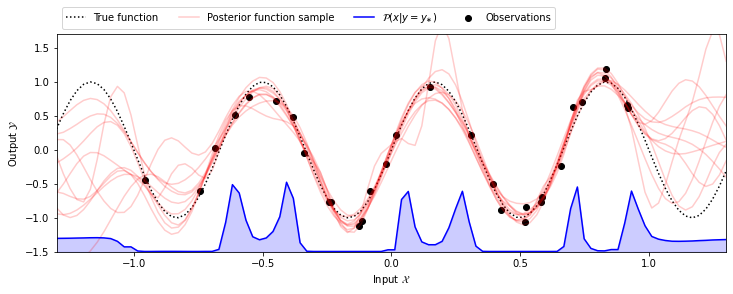

In [11]:
def likelihood_y(x):
    return gp_posterior(
        index_points=tf.reshape(x, [1, -1]),
        noiseless_functions=False
    )

def input_given_output(y):
    @tf.function
    def fn(x):
        # Assumes uniform prior on x.
        return likelihood_y(x).log_prob(y)
    return fn

given_y = 0.5
dist_input_given_output = construct(
    fn=input_given_output(y=given_y),
    is_log_fn=True,
    num_fn_calls=200,
    variables=Variables([Variable(lower=x_lb, upper=x_ub, name="Input given that y = %.1f" % given_y )]),
    callback=lambda i, current:
    print("#Iters: %s, #Partitions: %s. Log Z: %.2f" % (
      i + 1, current.num_partitions, np.log(current.z)
    )),
    callback_freq_fn_calls=20,
)
print("Approximation completed.")

fig = plt.figure(figsize=(12, 4))
plot_functions()
hs = np.array([
    dist_input_given_output(x) / dist_input_given_output.z 
    for x in predictive_index_points_
])
plt.plot(predictive_index_points_, -1.495 + 0.5 * hs, color="blue", label=r"$\mathcal{P}(x|y=y_{\ast})$")
plt.fill_between(
    predictive_index_points_.flatten(),
    -1.5, 
    -1.495 + 0.5 * hs.flatten(), 
    color="blue",
    alpha=0.2
)
plt.ylim(-1.5, 1.7)

plt.legend(
    loc='upper left',
    ncol=4,
    bbox_to_anchor=(0, 1.15)
)

We now compute $\mathcal{P}(x_{\ast}|y \geq y_{\ast})$

#Iters: 1, #Partitions: 3. Log Z: -2.49
#Iters: 7, #Partitions: 25. Log Z: -3.21
#Iters: 13, #Partitions: 47. Log Z: -3.06
#Iters: 18, #Partitions: 69. Log Z: -3.03
#Iters: 22, #Partitions: 89. Log Z: -3.03
#Iters: 26, #Partitions: 109. Log Z: -3.03
#Iters: 30, #Partitions: 129. Log Z: -3.03
#Iters: 34, #Partitions: 149. Log Z: -3.03
#Iters: 38, #Partitions: 171. Log Z: -3.03
#Iters: 42, #Partitions: 191. Log Z: -3.03
#Iters: 45, #Partitions: 203. Log Z: -3.03
Approximation completed.


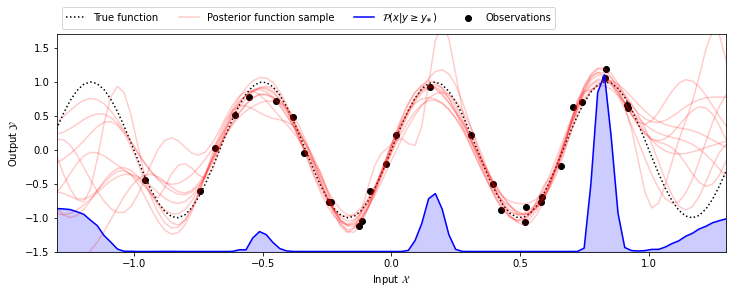

In [12]:
def input_given_output_larger_than(y):
    @tf.function
    def fn(x):
        # Assumes uniform prior on x.
        return 1 - likelihood_y(x).cdf(y)
    return fn

max_y_observed = np.max(observations_)
dist_input_given_output_larger_than = construct(
    fn=input_given_output_larger_than(y=max_y_observed),
    is_log_fn=False,
    num_fn_calls=200,
    variables=Variables([Variable(lower=x_lb, upper=x_ub, name="Input given that y > %.1f" % max_y_observed)]),
    callback=lambda i, current:
    print("#Iters: %s, #Partitions: %s. Log Z: %.2f" % (
      i + 1, current.num_partitions, np.log(current.z)
    )),
    callback_freq_fn_calls=20,
)
print("Approximation completed.")

fig = plt.figure(figsize=(12, 4))
plot_functions()
hs = np.array([
    dist_input_given_output_larger_than(x) / dist_input_given_output_larger_than.z 
    for x in predictive_index_points_
])
plt.plot(predictive_index_points_, -1.495 + 0.5 * hs, color="blue", label=r"$\mathcal{P}(x|y \geq y_{\ast})$")
plt.fill_between(
    predictive_index_points_.flatten(),
    -1.5, 
    -1.495 + 0.5 * hs.flatten(), 
    color="blue",
    alpha=0.2
)
plt.ylim(-1.5, 1.7)

plt.legend(
    loc='upper left',
    ncol=4,
    bbox_to_anchor=(0, 1.15)
)

### Marginalizing variables
We may also use DEFER in an inner loop to do integration.
This enables us to marginalize variables, such as when computing input distributions.

We now compute $\mathcal{P}(x_{\ast}) = \int \mathcal{P}(x_{\ast}|y = y_{\ast}) \mathcal{P}(y_{\ast})$

In [13]:
def plot_wide_side_panel():
  padding = 0.02
  panel_left = 4 * padding
  panel_width = 0.1

  main_left = panel_left + panel_width + padding
  main_width = 1 - main_left - padding

  bottom, height = 4 * padding, 1 - 5 * padding

  rect_side = [panel_left, bottom, panel_width, height]
  rect_main = [main_left, bottom, main_width, height]

  main_axis = plt.axes(rect_main)
  side_axis = plt.axes(rect_side)

  # no labels
  nullfmt = NullFormatter()
  main_axis.yaxis.set_major_formatter(nullfmt)
  side_axis.xaxis.set_major_formatter(nullfmt)

  return main_axis, side_axis

#Iters: 1, #Partitions: 3. Log Z: -0.67
#Iters: 8, #Partitions: 23. Log Z: -0.17
#Iters: 14, #Partitions: 45. Log Z: 0.06
#Iters: 19, #Partitions: 65. Log Z: 0.05
#Iters: 24, #Partitions: 85. Log Z: 0.11
#Iters: 29, #Partitions: 105. Log Z: 0.11
#Iters: 35, #Partitions: 125. Log Z: 0.11
#Iters: 41, #Partitions: 145. Log Z: 0.12
#Iters: 44, #Partitions: 153. Log Z: 0.12


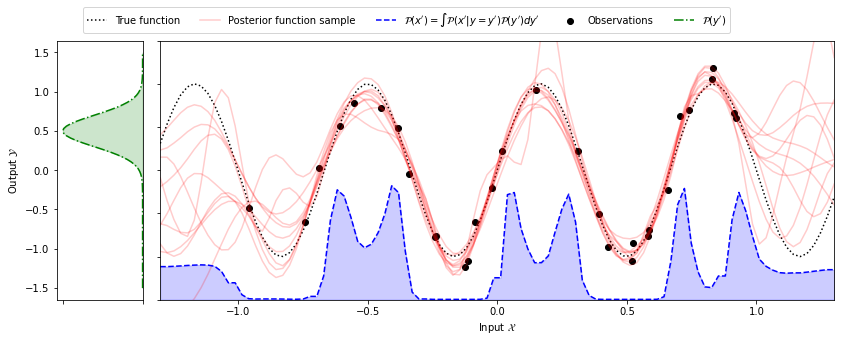

In [14]:
y_lb, y_ub = -1.5, 1.5

x_prime = Variable(lower=x_lb, upper=x_ub, name="x_prime")
y_prime = Variable(lower=y_lb, upper=y_ub, name="y_prime")

@tf.function
def log_likelihood_y(x, y):
    return likelihood_y(x).log_prob(y)

def y_prime_log_pdf(y_prime):
    return norm.logpdf(y_prime, loc=0.5, scale=0.2)

dist_input_marginalized_output = construct_marginal(
    fn=lambda x_prime, y_prime: log_likelihood_y(x_prime, y_prime) + y_prime_log_pdf(y_prime),
    is_log_fn=True,
    num_outer_fn_calls=150,
    num_inner_fn_calls=20,
    variables=Variables([x_prime, y_prime]),
    marginalize_variable_slices=[y_prime],
    callback=lambda i, current:
    print("#Iters: %s, #Partitions: %s. Log Z: %.2f" % (
      i + 1, current.num_partitions, np.log(current.z)
    )),
    callback_freq_fn_calls=20,
)

fig = plt.figure(figsize=(12, 4))

main_axis, side_axis = plot_wide_side_panel()

plot_functions(main_axis)
hs = np.array([
    dist_input_marginalized_output(x) / dist_input_marginalized_output.z
    for x in predictive_index_points_]
)

y_values = np.linspace(-1.5, 1.5, num=100)
y_prime_pdf_curve = np.array([np.exp(y_prime_log_pdf(y)) for y in y_values])

from matplotlib import pyplot, transforms
base = pyplot.gca().transData
rot = transforms.Affine2D().rotate_deg(90)

side_axis.set_xlim(-20, 2)

side_axis.plot(
    y_values, 
    y_prime_pdf_curve, 
    color="green", 
    transform=rot + base, 
    label="$\mathcal{P}(y')$",
    linestyle="dashdot"
)
side_axis.fill_between(
    y_values,
    np.zeros_like(y_prime_pdf_curve),
    y_prime_pdf_curve,
    color="green",
    alpha=0.2,
    transform=rot + base
)

side_axis.set_xlim(-2.15, 0.01)
side_axis.set_ylim(-1.65, 1.65)
main_axis.set_ylim((-1.5, 1.5))
side_axis.set_ylabel(r"Output $\mathcal{Y}$")

main_axis.plot(
    predictive_index_points_, 
    -1.495 + hs, 
    color="blue", 
    label="$\mathcal{P}(x')=\int \mathcal{P}(x'|y=y')\mathcal{P}(y')dy'$", 
    linestyle="dashed"
)
main_axis.fill_between(
    predictive_index_points_.flatten(),
    -1.495 * np.ones_like(predictive_index_points_).flatten(), 
    -1.495 + hs.flatten(), 
    color="blue",
    alpha=0.2
)

main_handles, main_labels = main_axis.get_legend_handles_labels()
side_handles, side_labels = side_axis.get_legend_handles_labels()

main_axis.set_ylabel("")

plt.legend(
    main_handles + side_handles, 
    main_labels + side_labels, 
    loc='upper left',
    ncol=5,
    bbox_to_anchor=(0.25, 1.15)
)

Analogously, we could compute the distribution of the output given a distribution over the input,
$\mathcal{P}(y_{\ast}) = \int \mathcal{P}(y|x=x_{\ast}) \mathcal{P}(x_{\ast})$.

#Iters: 1, #Partitions: 3. Log Z: 0.32
#Iters: 7, #Partitions: 25. Log Z: -0.04
#Iters: 12, #Partitions: 45. Log Z: -0.03
#Iters: 15, #Partitions: 53. Log Z: -0.02


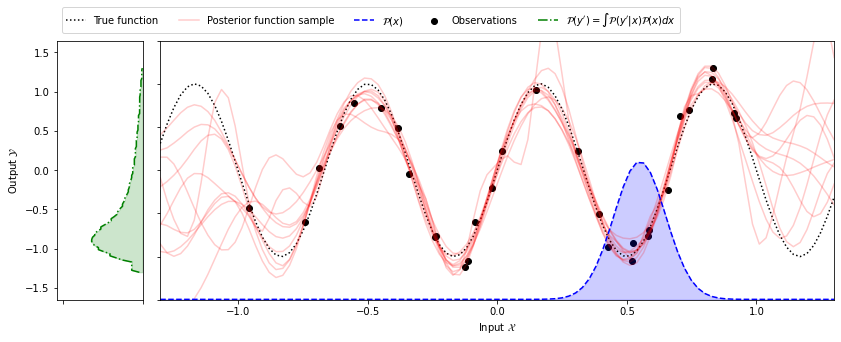

In [15]:
def x_prime_log_pdf(x):
    return norm.logpdf(x, loc=0.55, scale=0.10)

dist_output_marginalized_input = construct_marginal(
    fn=lambda x_prime, y_prime: log_likelihood_y(x_prime, y_prime) + x_prime_log_pdf(x_prime),
    is_log_fn=True,
    num_outer_fn_calls=50,
    num_inner_fn_calls=50,
    marginalize_variable_slices=[x_prime],
    variables=Variables([x_prime, y_prime]),
    callback=lambda i, current:
    print("#Iters: %s, #Partitions: %s. Log Z: %.2f" % (
      i + 1, current.num_partitions, np.log(current.z)
    )),
    callback_freq_fn_calls=20,
)

fig = plt.figure(figsize=(12, 4))

main_axis, side_axis = plot_wide_side_panel()

plot_functions(main_axis)
x_pdf_curve = np.array([np.exp(x_prime_log_pdf(x)) for x in predictive_index_points_])
main_axis.plot(
    predictive_index_points_, 
    -1.495 + 0.4 * x_pdf_curve,
    color="blue", 
    label="$\mathcal{P}(x)$", 
    linestyle="dashed"
)
main_axis.fill_between(
    predictive_index_points_.flatten(),
    -1.495 * np.ones_like(x_pdf_curve).flatten(), 
    -1.495 + 0.4 * x_pdf_curve.flatten(), 
    color="blue",
    alpha=0.2
)

from matplotlib import pyplot, transforms
base = pyplot.gca().transData
rot = transforms.Affine2D().rotate_deg(90)

hs = np.array([
    dist_output_marginalized_input(x) / dist_output_marginalized_input.z 
    for x in predictive_index_points_
])
side_axis.plot(
    predictive_index_points_, 
    hs, 
    color="green", 
    transform=rot + base, 
    label="$\mathcal{P}(y')=\int \mathcal{P}(y'|x)\mathcal{P}(x)dx$",
    linestyle="dashdot"
)
side_axis.fill_between(
    predictive_index_points_.flatten(),
    np.zeros_like(hs).flatten(),
    hs.flatten(),
    color="green",
    alpha=0.2,
    transform=rot + base
)
side_axis.set_xlim(-2.15, 0.01)
side_axis.set_ylim(-1.65, 1.65)
main_axis.set_ylim((-1.5, 1.5))
side_axis.set_ylabel(r"Output $\mathcal{Y}$")

main_handles, main_labels = main_axis.get_legend_handles_labels()
side_handles, side_labels = side_axis.get_legend_handles_labels()

main_axis.set_ylabel("")

plt.legend(
    main_handles + side_handles, 
    main_labels + side_labels, 
    loc='upper left',
    ncol=5,
    bbox_to_anchor=(0., 1.15)
)

### Bayesian Optimization
Input distributions are useful for example in Bayesian Optimization.

Setting the next query x in a BO loop to be the mode of $\mathcal{P}(x|y \geq y_{\text{max observed}})$ corresponds to usage of the Probability of Improvement acqusition function. Instead we may choose to, for example, sample from the full distribution as new locations to evaluate.

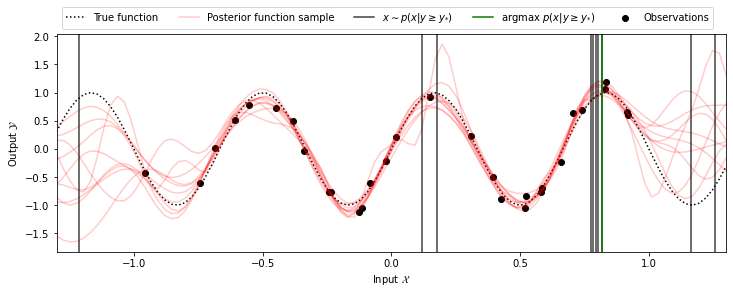

In [16]:
x_of_larger_y_mode = dist_input_given_output_larger_than.mode()
x_of_larger_y_samples, = dist_input_given_output_larger_than.sampler()(10)

fig = plt.figure(figsize=(12, 4))
plot_functions()
for i, x in enumerate(x_of_larger_y_samples):
    plt.axvline(x=x, color="black", label="$x \sim p(x|y \geq y_{*})$" if i == 0 else None, alpha=0.75)
plt.axvline(x=x_of_larger_y_mode, color="green", label="argmax $p(x|y \geq y_{*})$")
plot_legend()

plt.legend(
    loc='upper left',
    ncol=5,
    bbox_to_anchor=(0, 1.15)
)